In [44]:
import pandas as pd

df = pd.read_csv("alarms.csv")

df["time"] = pd.to_datetime(df["time"])

df = df.drop(columns=["threat"])

print(df.head())


                 time      cities    id       description origin
0 2019-06-13 00:17:00       נירים  5665  ירי רקטות וטילים   Gaza
1 2019-06-13 20:56:00       איבים  5671  ירי רקטות וטילים   Gaza
2 2019-06-13 20:56:00       שדרות  5671  ירי רקטות וטילים   Gaza
3 2019-06-18 10:06:00  אשדוד - יא  5672  ירי רקטות וטילים   Gaza
4 2019-06-18 10:06:00       מרינה  5672  ירי רקטות וטילים   Gaza


In [45]:
print(df.columns)

Index(['time', 'cities', 'id', 'description', 'origin'], dtype='object')


In [46]:
import pandas as pd
coords = pd.read_csv("coord.csv")  # columns: loc, lat, long
coords = coords.drop_duplicates(subset="loc")

In [47]:
# Quick check
print(coords.head())

# Merge with main DataFrame
# Assuming df["origin"] matches coords["loc"]
df = df.merge(coords, left_on="cities", right_on="loc", how="left")

# Drop 'loc' column from merge, since it's the same as 'origin'
df.drop(columns=["loc"], inplace=True)

print(df.head())


          loc        lat       long
0   'ביר הדאג  31.023160  34.709138
1     אבו גוש  31.806800  35.110300
2    אבו נוור  31.762100  35.293800
3    אבו סנאן  32.958000  35.172000
4  אבו קרינאת  31.103115  34.952003
                 time      cities    id       description origin        lat  \
0 2019-06-13 00:17:00       נירים  5665  ירי רקטות וטילים   Gaza  31.335700   
1 2019-06-13 20:56:00       איבים  5671  ירי רקטות וטילים   Gaza  31.533597   
2 2019-06-13 20:56:00       שדרות  5671  ירי רקטות וטילים   Gaza  31.522694   
3 2019-06-18 10:06:00  אשדוד - יא  5672  ירי רקטות וטילים   Gaza  31.784574   
4 2019-06-18 10:06:00       מרינה  5672  ירי רקטות וטילים   Gaza  31.680779   

        long  
0  34.394100  
1  34.609697  
2  34.595581  
3  34.631308  
4  34.557664  


In [48]:
# How many nulls in each column
df.isnull().sum()


time            0
cities          0
id              0
description     0
origin         70
lat             0
long            0
dtype: int64

In [49]:
print("Unique values in description:")
print(df["description"].unique())

print("\n" + "="*50 + "\n")

print("Unique values in origin:")
print(df["origin"].unique())


Unique values in description:
['ירי רקטות וטילים' 'חדירת מחבלים' 'חדירת כלי טיס עוין' 'אזהרה'
 'רעידת אדמה']


Unique values in origin:
['Gaza' 'Lebanon' 'Syria' nan 'FA' 'Yemen' 'Israel' 'Iraq' 'Iran']


In [50]:
description_counts = df["description"].value_counts()

print("ספירה של כל סוגי ההתראות:")
print(description_counts)


ספירה של כל סוגי ההתראות:
description
ירי רקטות וטילים      77017
חדירת כלי טיס עוין     8072
רעידת אדמה              549
חדירת מחבלים             56
אזהרה                     1
Name: count, dtype: int64


In [51]:
origin_counts = df["origin"].value_counts()

print("ספירה של כל סוגי המדינות:")
print(origin_counts)


ספירה של כל סוגי המדינות:
origin
Iran       25808
Gaza       22249
Lebanon    21327
Yemen      13236
FA          2821
Iraq          75
Syria         74
Israel        35
Name: count, dtype: int64


In [52]:
# Filter records originating from Israel
israel_alerts = df[df["origin"] == "Israel"]

# Count by description
israel_counts = israel_alerts["description"].value_counts()

print("סוגי ההתראות עבור origin = Israel:")
print(israel_counts)


סוגי ההתראות עבור origin = Israel:
description
ירי רקטות וטילים    35
Name: count, dtype: int64


In [53]:
# Earthquake filtering
earthquakes = df[df["description"] == "רעידת אדמה"]

# Count by origin
earthquake_origins = earthquakes["origin"].value_counts()

print("רעידות אדמה לפי מקור:")
print(earthquake_origins)


רעידות אדמה לפי מקור:
origin
FA    549
Name: count, dtype: int64


In [54]:
# Filter only for 'חדירת מחבלים'
infiltration_alerts = df[df["description"] == 'חדירת מחבלים']

# Count by origin
infiltration_by_origin = infiltration_alerts["origin"].value_counts()

print("Hostile Infiltration alerts by origin:")
print(infiltration_by_origin)


Hostile Infiltration alerts by origin:
Series([], Name: count, dtype: int64)


In [55]:
target_descriptions = ['ירי רקטות וטילים', 'חדירת כלי טיס עוין']

# Filter the DataFrame
# Keep only rows where the value in the description column is in our list
df = df[df["description"].isin(target_descriptions)].copy()

In [56]:
df.to_csv('data.csv', index=False)

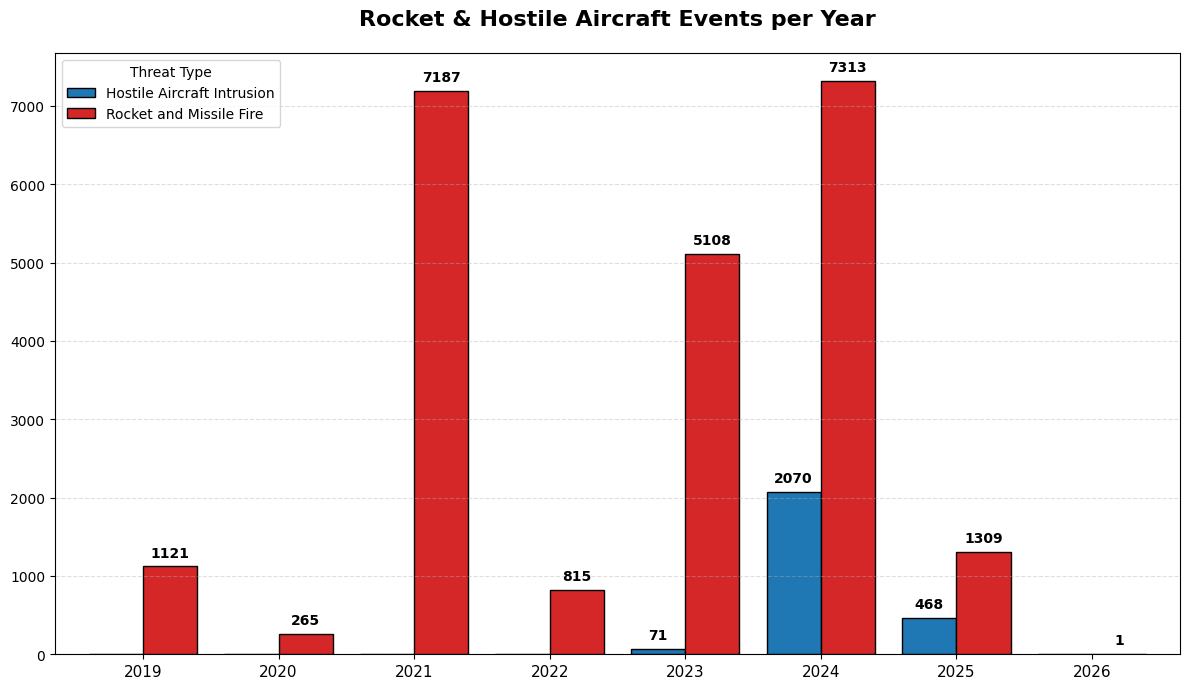

In [57]:
import matplotlib.pyplot as plt
import pandas as pd

# Preparing the data
df["time"] = pd.to_datetime(df["time"])

# Filter origin and descriptions
origin = ["Iran", "Gaza", "Lebanon", "Yemen", "Iraq", "Syria", None, ""]
description_mapping = {
    'ירי רקטות וטילים': 'Rocket and Missile Fire',
    'חדירת כלי טיס עוין': 'Hostile Aircraft Intrusion'
}

# Initial filtering by alert type and origin
filtered_df = df[
    df["description"].isin(description_mapping.keys()) &
    (df["origin"].isin(origin) | df["origin"].isna())
].copy()

# Removing duplicates (counting each event once by combination of ID and time)
unique_events = filtered_df.drop_duplicates(subset=['id', 'time']).copy()

# Preparing the data for the graph
unique_events["year"] = unique_events["time"].dt.year
unique_events["description_en"] = unique_events["description"].map(description_mapping)

# Create the pivot table for the annual count
yearly_counts = (
    unique_events
    .groupby(["year", "description_en"])
    .size()
    .unstack(fill_value=0)
)

# Creating the graph
colors = ['#1f77b4', '#d62728']

ax = yearly_counts.plot(kind="bar", figsize=(12, 7), color=['#1f77b4', '#d62728'], edgecolor='black', width=0.8)

plt.title("Rocket & Hostile Aircraft Events per Year", fontsize=16, fontweight='bold', pad=20)

plt.xlabel("")
plt.ylabel("")

plt.xticks(rotation=0, fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.legend(title="Threat Type", frameon=True, loc='upper left')

for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(str(int(p.get_height())),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [66]:
import plotly.express as px
import pandas as pd

origin = ["Iran", "Gaza", "Lebanon", "Yemen", "Iraq", "Syria", None, ""]

df_filtered = df[df["origin"].isin(origin) | df["origin"].isna()].copy()

unique_events = df_filtered.drop_duplicates(subset=['id', 'time']).copy()

unique_events['date_only'] = unique_events['time'].dt.date
daily_counts = unique_events.groupby('date_only').size().reset_index(name='event_count')

min_date = daily_counts['date_only'].min()
max_date = daily_counts['date_only'].max()
max_y = daily_counts['event_count'].max() * 1.05

start_year = min_date.year
end_year = max_date.year
years_dates = [pd.to_datetime(f"{year}-01-01") for year in range(start_year, end_year + 2)]
years_labels = [str(year) for year in range(start_year, end_year + 2)]

operations = [
    {"date": "2019-11-12", "name": "Black Belt"},
    {"date": "2021-05-10", "name": "Guardian of the Walls"},
    {"date": "2022-08-05", "name": "Breaking Dawn"},
    {"date": "2023-05-09", "name": "Shield and Arrow"},
    {"date": "2023-10-07", "name": "Iron Swords"},
]
op_dates = [pd.to_datetime(op["date"]) for op in operations]
op_labels = [f"<b>{op['name']}</b>" for op in operations]

all_tick_vals = years_dates + op_dates
all_tick_text = years_labels + op_labels

fig = px.bar(
    daily_counts,
    x='date_only',
    y='event_count',
    template="plotly_white",
    title="Daily Rocket, Missile & Hostile Aircraft Events in Israel"
)

fig.update_traces(marker_color='#FF0000', marker_line_width=0)

fig.update_layout(
    dragmode='pan',
    hovermode="x",
    bargap=0.1,
    title_font_size=24,
    title_x=0.5,
    xaxis=dict(
        title=None,
        range=[min_date, max_date],
        autorange=False,
        fixedrange=False,
        tickmode='array',
        tickvals=all_tick_vals,
        ticktext=all_tick_text,
        tickangle=-90,
        tickfont=dict(color='black', size=11),
        showgrid=True,
        gridcolor='rgba(200, 200, 200, 0.2)',
        linecolor='black',
        linewidth=2
    ),
    yaxis=dict(
        title=None,
        range=[0, max_y],
        fixedrange=True,
        showgrid=True,
        gridcolor='lightgray'
    ),
    margin=dict(b=150, t=100)
)

config = {'scrollZoom': True, 'displayModeBar': False}

fig.show(config=config)
fig.write_html("Israel_security_events.html", config=config)

print(f"Graph finalized and saved. Total unique events: {len(unique_events)}")

Graph finalized and saved. Total unique events: 25782


In [67]:
import plotly.express as px
import pandas as pd

origin = ["Iran", "Gaza", "Lebanon", "Yemen", "Iraq", "Syria"]

df_filtered = df[df["origin"].isin(origin)].copy()

unique_events = df_filtered.drop_duplicates(subset=['id', 'time']).copy()

# Monthly Aggregation
# Convert each date to the first day of that month for grouping purposes
unique_events['month'] = unique_events['time'].dt.to_period('M').dt.to_timestamp()

monthly_counts = unique_events.groupby(['month', 'origin']).size().reset_index(name='event_count')

min_date = monthly_counts['month'].min()
max_date = monthly_counts['month'].max()
max_y = monthly_counts.groupby('month')['event_count'].sum().max() * 1.1

years_dates = [pd.to_datetime(f"{year}-01-01") for year in range(min_date.year, max_date.year + 2)]
years_labels = [str(year) for year in range(min_date.year, max_date.year + 2)]

operations = [
    {"date": "2019-11-01", "name": "Black Belt"},
    {"date": "2021-05-01", "name": "Guardian of the Walls"},
    {"date": "2022-08-01", "name": "Breaking Dawn"},
    {"date": "2023-05-01", "name": "Shield and Arrow"},
    {"date": "2023-10-01", "name": "Iron Swords"}
]
op_dates = [pd.to_datetime(op["date"]) for op in operations]
op_labels = [f"<b>{op['name']}</b>" for op in operations]

all_tick_vals = years_dates + op_dates
all_tick_text = years_labels + op_labels

fig = px.bar(
    monthly_counts,
    x='month',
    y='event_count',
    color='origin',
    template="plotly_white",
    title="Monthly Threats by Origin",
    color_discrete_map={
        "Gaza": "#FF0000",
        "Lebanon": "#008000",
        "Iran": "#000000",
        "Yemen": "#FF8C00",
        "Iraq": "#800080",
        "Syria": "#00BFFF"
    }
)

fig.update_layout(
    dragmode='pan',
    hovermode="x unified",
    barmode='stack',
    title_font_size=24,
    title_x=0.5,
    xaxis=dict(
        title=None,
        range=[min_date, max_date],
        autorange=False,
        fixedrange=False,
        tickmode='array',
        tickvals=all_tick_vals,
        ticktext=all_tick_text,
        tickangle=-90,
        tickfont=dict(color='black', size=11),
        showgrid=True,
        gridcolor='rgba(200, 200, 200, 0.2)',
        linecolor='black',
        linewidth=2
    ),
    yaxis=dict(
        title=None,
        range=[0, max_y],
        fixedrange=True,
        showgrid=True,
        gridcolor='lightgray'
    ),
    legend_title_text='Origin',
    margin=dict(b=150, t=100)
)
config = {'scrollZoom': True, 'displayModeBar': False}

fig.show(config=config)
fig.write_html("monthly_events_by_origin.html", config=config)

print(f"Monthly grouped graph saved. Total events after filtering: {len(unique_events)}")

Monthly grouped graph saved. Total events after filtering: 25716


In [68]:
import plotly.express as px

origin = ["Iran", "Gaza", "Lebanon", "Yemen", "Iraq", "Syria"]

df_filtered = df[df["origin"].isin(origin)].copy()
unique_events = df_filtered.drop_duplicates(subset=['id', 'time']).copy()

unique_events['hour'] = unique_events['time'].dt.hour
hour_labels = {
    h: f"{h if 0 < h <= 12 else (h-12 if h > 12 else 12)} {'AM' if h < 12 else 'PM'}"
    for h in range(24)
}

hourly_counts = (
    unique_events
    .groupby(['hour', 'origin'])
    .size()
    .reset_index(name='event_count')
)

hourly_counts['hour_label'] = hourly_counts['hour'].map(hour_labels)

max_y = hourly_counts['event_count'].max() * 1.1

fig = px.bar(
    hourly_counts,
    x='hour',
    y='event_count',
    color='origin',
    template="plotly_white",
    title="Threats Distribution by Hour",
    color_discrete_map={
        "Gaza": "#FF0000",
        "Lebanon": "#008000",
        "Iran": "#000000",
        "Yemen": "#FF8C00",
        "Iraq": "#800080",
        "Syria": "#00BFFF"
    }
)

fig.update_layout(
    barmode='group',
    bargap=0.08,
    title_font_size=24,
    title_x=0.5,

    xaxis=dict(
        title=None,
        tickmode='array',
        tickvals=list(range(24)),
        ticktext=[hour_labels[h] for h in range(24)],
        tickangle=-45,
        linecolor='black',
        linewidth=2,
        range=[-0.5, 23.5]
    ),

    yaxis=dict(
        title="",
        range=[0, max_y],
        showgrid=True,
        gridcolor='lightgray'
    ),

    legend=dict(
        x=0.99,
        y=0.99,
        xanchor='right',
        yanchor='top',
        bgcolor='rgba(255,255,255,0.7)',
        bordercolor='black',
        borderwidth=1
    ),

    margin=dict(l=50, r=10, b=100, t=100)
)

config = {'displayModeBar': False}
fig.show(config=config)
fig.write_html("events_by_hour_ampm.html", config=config)

print("The hourly graph with AM/PM labels is ready.")


The hourly graph with AM/PM labels is ready.


In [79]:
# BAR CHART RACE: Cumulative Alerts by City (Iron Swords)
import plotly.graph_objects as go
import pandas as pd

# Ensure datetime
df['time'] = pd.to_datetime(df['time'])

# Filter: Iron Swords period + specific origins
start_date = pd.to_datetime('2023-10-07')
valid_origins = ["Iran", "Gaza", "Lebanon", "Yemen", "Iraq", "Syria"]

df_filtered = df[
    (df['time'] >= start_date) &
    (df['origin'].isin(valid_origins))
].copy()

# Remove duplicate events (same time + city)
unique_events = df_filtered.drop_duplicates(subset=['time', 'cities']).copy()
unique_events = unique_events.rename(columns={'cities': 'city'})
unique_events = unique_events[unique_events['city'].notna() & (unique_events['city'] != "")]

# Add date column
unique_events['date'] = unique_events['time'].dt.strftime('%Y-%m-%d')

# Daily counts per city
daily_counts = unique_events.groupby(['date', 'city']).size().reset_index(name='daily_count')

print(f"   ✓ Date range: {daily_counts['date'].min()} to {daily_counts['date'].max()}")
print(f"   ✓ Unique cities: {daily_counts['city'].nunique()}")

# Create complete date × city matrix
all_dates = sorted(daily_counts['date'].unique())
all_cities = daily_counts['city'].unique()

full_index = pd.MultiIndex.from_product([all_dates, all_cities], names=['date', 'city'])
full_df = pd.DataFrame(index=full_index).reset_index()

# Merge with actual counts
final_df = pd.merge(full_df, daily_counts, on=['date', 'city'], how='left').fillna(0)
final_df['daily_count'] = final_df['daily_count'].astype(int)

# Calculate cumulative sum per city
final_df['cumulative_count'] = final_df.groupby('city')['daily_count'].cumsum()


num_of_cities = 25

# Rank cities by cumulative count (1 = highest)
final_df['rank'] = final_df.groupby('date')['cumulative_count'].rank(
    method='first',  # Consistent tie-breaking
    ascending=False
)

# Keep only top N cities per day
top_n_df = final_df[final_df['rank'] <= num_of_cities].copy()

# Sort by date and rank (critical for smooth animation!)
top_n_df = top_n_df.sort_values(['date', 'rank']).reset_index(drop=True)

print(f"   ✓ Top {num_of_cities} cities tracked")


# Consistent color per city (same city = same color throughout animation)
unique_cities_in_top = top_n_df['city'].unique()

color_palette = [
    '#E63946', '#F4A261', '#2A9D8F', '#457B9D', '#1D3557',
    '#E9C46A', '#264653', '#A8DADC', '#F1FAEE', '#D62828',
    '#003049', '#FCBF49', '#EAE2B7', '#9B2335', '#0B525B',
    '#006D77', '#83C5BE', '#FFDDD2', '#E29578', '#8338EC',
    '#3A86FF', '#FF006E', '#FB5607', '#FFBE0B', '#8AC926'
]

colors = {}
for i, city in enumerate(unique_cities_in_top):
    colors[city] = color_palette[i % len(color_palette)]


# Fixed x-axis range (prevents jumping)
max_count = top_n_df['cumulative_count'].max()

# Sample dates (every 3rd day to reduce file size)
dates_to_animate = sorted(top_n_df['date'].unique())[::3]

frames = []
for date in dates_to_animate:
    # Get data for this frame, sorted by rank (descending so rank 1 is at top)
    frame_data = top_n_df[top_n_df['date'] == date].sort_values('rank', ascending=False)

    frame = go.Frame(
        data=[go.Bar(
            x=frame_data['cumulative_count'],
            y=frame_data['city'],
            orientation='h',
            marker=dict(
                color=[colors.get(c, '#888888') for c in frame_data['city']],
                line=dict(width=0)
            ),
            text=frame_data['cumulative_count'].astype(int),
            textposition='outside',
            textfont=dict(size=11),
            hovertemplate='<b>%{y}</b><br>Alerts: %{x:,}<extra></extra>'
        )],
        name=date,
        layout=go.Layout(
            title=dict(
                text=f"<b>Cumulative Alerts by City</b><br><sup>Iron Swords | {date}</sup>"
            )
        )
    )
    frames.append(frame)


# Initial frame
initial_date = dates_to_animate[0]
initial_data = top_n_df[top_n_df['date'] == initial_date].sort_values('rank', ascending=False)

fig = go.Figure(
    data=[go.Bar(
        x=initial_data['cumulative_count'],
        y=initial_data['city'],
        orientation='h',
        marker=dict(
            color=[colors.get(c, '#888888') for c in initial_data['city']],
            line=dict(width=0)
        ),
        text=initial_data['cumulative_count'].astype(int),
        textposition='outside',
        textfont=dict(size=11)
    )],
    frames=frames
)


fig.update_layout(
    # Title
    title = '<b>Cumulative Alerts by City</b><br><sup>Iron Swords</sup>',

    # X-axis
    xaxis=dict(
        title="Cumulative Alert Count",
        range=[0, max_count * 1.15],
        showgrid=True,
        gridcolor='lightgray',
        tickformat=',d'
    ),

    # Y-axis
    yaxis=dict(
        title="",
        tickfont=dict(size=11)
    ),

    # General
    showlegend=False,
    template='plotly_white',
    height=750,
    width=1000,
    margin=dict(l=180, r=80, t=100, b=80),

    # Animation controls
    updatemenus=[
        dict(
            type='buttons',
            showactive=False,
            y=-0.08,
            x=0,
            xanchor='right',
            buttons=[
                dict(
                    label='▶ Play',
                    method='animate',
                    args=[
                        None,
                        dict(
                            frame=dict(duration=300, redraw=True),  # 300ms per frame
                            fromcurrent=True,
                            transition=dict(duration=150, easing='linear')
                        )
                    ]
                ),
                dict(
                    label='⏸ Pause',
                    method='animate',
                    args=[
                        [None],
                        dict(
                            frame=dict(duration=0, redraw=False),
                            mode='immediate',
                            transition=dict(duration=0)
                        )
                    ]
                )
            ]
        )
    ],

    # Slider
    sliders=[
        dict(
            active=0,
            yanchor='top',
            xanchor='left',
            currentvalue=dict(
                font=dict(size=14),
                prefix='Date: ',
                visible=True,
                xanchor='center'
            ),
            transition=dict(duration=150, easing='linear'),
            pad=dict(b=10, t=50),
            len=0.9,
            x=0.05,
            y=0,
            steps=[
                dict(
                    args=[
                        [f.name],
                        dict(
                            frame=dict(duration=150, redraw=True),
                            mode='immediate',
                            transition=dict(duration=150, easing='linear')
                        )
                    ],
                    label=f.name,
                    method='animate'
                )
                for f in frames
            ]
        )
    ]
)

output_file = "bar_chart_race.html"
fig.write_html(output_file, include_plotlyjs=True, full_html=True)

fig.show()

   ✓ Date range: 2023-10-07 to 2025-10-07
   ✓ Unique cities: 1463
   ✓ Top 25 cities tracked


In [71]:
import plotly.express as px
import pandas as pd

color_map = {
    "Gaza": "#FF0000",
    "Lebanon": "#008000",
    "Iran": "#000000",
    "Yemen": "#FF8C00",
}
origin = list(color_map.keys())

# Data preparation (from 6.10.23)
df['time'] = pd.to_datetime(df['time'])
start_date = pd.to_datetime('2023-10-06')
df_filtered = df[(df['time'] >= start_date) & (df["origin"].isin(origin))].copy()

unique_events = df_filtered.drop_duplicates(subset=['id', 'time']).copy()

unique_events['date'] = unique_events['time'].dt.date
daily_counts = unique_events.groupby(['date', 'origin']).size().reset_index(name='daily_count')

all_dates = pd.date_range(start=start_date.date(), end=daily_counts['date'].max()).date
full_index = pd.MultiIndex.from_product([all_dates, origin], names=['date', 'origin'])
full_df = pd.DataFrame(index=full_index).reset_index()

cumulative_df = pd.merge(full_df, daily_counts, on=['date', 'origin'], how='left').fillna(0)
cumulative_df['cumulative_count'] = cumulative_df.groupby('origin')['daily_count'].cumsum()

events = [
    {"date": "2023-10-07", "text": "Hamas attack", "origin": "Gaza"},
    {"date": "2023-11-02", "text": "Ground incursion", "origin": "Gaza"},
    {"date": "2023-11-24", "text": "Ceasefire begins", "origin": "Gaza"},
    {"date": "2023-11-30", "text": "Ceasefire ends", "origin": "Gaza"},
    {"date": "2024-09-18", "text": "Pager operation", "origin": "Lebanon"},
    {"date": "2024-09-27", "text": "Assassination of Nasrallah", "origin": "Lebanon"},
    {"date": "2024-11-27", "text": "Ceasefire begins", "origin": "Lebanon"},
    {"date": "2025-01-19", "text": "Ceasefire begins", "origin": "Gaza"},
    {"date": "2025-02-18", "text": "Ceasefire ends", "origin": "Lebanon"},
    {"date": "2025-03-18", "text": "Ceasefire ends", "origin": "Gaza"},
    {"date": "2025-06-13", "text": "Operation Rising Lion", "origin": "Iran"},
    {"date": "2025-08-28", "text": "Operation Tipat Mazal", "origin": "Yemen"}
]

fig = px.line(
    cumulative_df, x='date', y='cumulative_count', color='origin',
    template="plotly_white", title="Cumulative Threats by Source: Iron Swords Period",
    color_discrete_map=color_map
)

for ev in events:
    ev_date = pd.to_datetime(ev["date"]).date()
    y_val = cumulative_df[(cumulative_df['date'] == ev_date) &
                          (cumulative_df['origin'] == ev['origin'])]['cumulative_count']

    if not y_val.empty:
        y_offset = -40

        if ev["date"] == "2023-11-30":
            y_offset = -80

        fig.add_annotation(
            x=ev["date"],
            y=y_val.values[0],
            text=ev["text"],
            showarrow=True,
            arrowhead=1,
            ax=0, ay=y_offset,
            font=dict(size=10, color="black"),
            bgcolor="rgba(255, 255, 255, 0.9)",
            bordercolor=color_map.get(ev['origin'], "gray"),
            borderwidth=2
        )

fig.update_layout(
    dragmode='pan', hovermode="closest", title_font_size=24, title_x=0.5,
    xaxis=dict(title=None, range=[start_date.date(), cumulative_df['date'].max()], showgrid=True, linecolor='black'),
    yaxis=dict(title="Cumulative Events", showgrid=True, gridcolor='lightgray'),
    margin=dict(b=80, t=100)
)

fig.update_traces(line=dict(width=3))

fig.show()
fig.write_html("cumulative_iron_swords_lines.html")

In [74]:
import plotly.express as px
import pandas as pd


print("ANIMATED BUBBLE MAP: Alert Locations by Launch Origin")
print("Iron Swords Period")

# LOAD DATA
try:
    df = pd.read_csv("alarms.csv")
except:
    df = pd.read_csv("alarms__1_.csv")

coords = pd.read_csv("coord.csv")
coords.columns = ['city', 'lat', 'lon']
coords['city'] = coords['city'].str.replace("'", "").str.strip()
coords = coords.drop_duplicates(subset="city")


# MERGE AND FILTER
df['cities'] = df['cities'].str.strip()
df_merged = df.merge(coords, left_on="cities", right_on="city", how="left")
df_merged['time'] = pd.to_datetime(df_merged['time'])

# Filter: Iron Swords period (from Oct 7, 2023)
start_date = pd.to_datetime('2023-10-07')
df_map = df_merged[df_merged['time'] >= start_date].dropna(subset=['lat', 'lon']).copy()

# Rename for clarity, remove Unknown
origin_rename = {
    'Gaza': 'Gaza',
    'Lebanon': 'Lebanon',
    'Yemen': 'Yemen',
    'Iran': 'Iran',
    'Iraq': 'Iraq',
    'Syria': 'Syria',
    'FA': 'Fighting Area',
    'Israel': 'Israel'
}

df_map['origin_clean'] = df_map['origin'].map(origin_rename)
df_map = df_map[df_map['origin_clean'].notna()].copy()

# CREATE TIME PERIODS
df_map['year_month'] = df_map['time'].dt.to_period('M').astype(str)
all_months = sorted(df_map['year_month'].unique())


# AGGREGATE DATA
agg_data = df_map.groupby(
    ['year_month', 'cities', 'lat', 'lon', 'origin_clean']
).size().reset_index(name='alert_count')


# LEGEND - placeholder for each origin in each month
# Define all origins we want in legend (in order)
all_origins = ['Gaza', 'Lebanon', 'Yemen', 'Iran', 'Fighting Area', 'Iraq', 'Syria', 'Israel']

# Create placeholder rows: one invisible point per origin per month
# Location: off-screen (lat=0, lon=0) with size=0
placeholders = []
for month in all_months:
    for origin in all_origins:
        placeholders.append({
            'year_month': month,
            'cities': f'_placeholder_{origin}',
            'lat': 29.5,  # South of Israel, barely visible
            'lon': 34.5,
            'origin_clean': origin,
            'alert_count': 0.1  # Tiny size, almost invisible
        })

placeholder_df = pd.DataFrame(placeholders)

# Combine real data with placeholders
agg_data_fixed = pd.concat([agg_data, placeholder_df], ignore_index=True)


origin_colors = {
    'Gaza': '#FF0000',
    'Lebanon': '#008000',
    'Yemen': '#FF8C00',
    'Iran': '#000000',
    'Iraq': '#800080',
    'Syria': '#00BFFF',
    'Fighting Area': '#8B4513',
    'Israel': '#0000FF'
}


# CREATE ANIMATED MAP
print("\n" + "-" * 50)
print("Creating Animated Map")
print("-" * 50)

fig = px.scatter_mapbox(
    agg_data_fixed,
    lat='lat',
    lon='lon',
    size='alert_count',
    color='origin_clean',
    color_discrete_map=origin_colors,
    category_orders={'origin_clean': all_origins},
    hover_name='cities',
    hover_data={
        'alert_count': ':,',
        'origin_clean': True,
        'year_month': True,
        'lat': False,
        'lon': False
    },
    animation_frame='year_month',
    animation_group='cities',
    center=dict(lat=31.5, lon=34.8),
    zoom=7,
    mapbox_style='carto-positron',
    size_max=35,
    labels={
        'origin_clean': 'Launch Origin',
        'alert_count': 'Alerts',
        'year_month': 'Month'
    },
    title='<b>Alert Locations by Launch Origin</b><br><sup>Iron Swords Period (Oct 2023 - Oct 2025) | Bubble size = number of alerts</sup>'
)

fig.update_layout(
    width=1100,
    height=800,

    # Fixed legend
    legend=dict(
        title=dict(
            text='<b>Launch Origin</b>',
            font=dict(size=16, color='black')
        ),
        font=dict(size=14, color='black'),
        bgcolor='white',
        bordercolor='black',
        borderwidth=2,
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.01,
        itemsizing='constant',
        itemwidth=50,
        traceorder='normal'
    ),

    title=dict(
        font=dict(size=20),
        x=0.5
    ),

    margin=dict(l=10, r=10, t=80, b=10),

    # Animation controls
    updatemenus=[
        dict(
            type='buttons',
            showactive=False,
            y=-0.05,
            x=0.1,
            buttons=[
                dict(
                    label='▶ Play',
                    method='animate',
                    args=[None, dict(
                        frame=dict(duration=500, redraw=True),
                        transition=dict(duration=200)
                    )]
                ),
                dict(
                    label='⏸ Pause',
                    method='animate',
                    args=[[None], dict(
                        frame=dict(duration=0),
                        mode='immediate'
                    )]
                )
            ]
        )
    ],

    # Slider
    sliders=[
        dict(
            active=0,
            currentvalue=dict(
                font=dict(size=16),
                prefix='<b>Month: </b>',
                visible=True,
                xanchor='center'
            ),
            transition=dict(duration=200),
            pad=dict(b=10, t=50),
            len=0.9,
            x=0.05,
            y=0,
            steps=[
                dict(
                    args=[[f.name], dict(
                        frame=dict(duration=200),
                        mode='immediate',
                        transition=dict(duration=200)
                    )],
                    label=f.name,
                    method='animate'
                )
                for f in fig.frames
            ]
        )
    ]
)

# Filter out placeholder hover
fig.update_traces(
    hovertemplate='<b>%{hovertext}</b><br>Alerts: %{marker.size:,}<br>Origin: %{customdata[1]}<extra></extra>'
)


output_file = "MAP_Alert_Locations_by_Launch_Origin_Iron_Swords.html"
fig.write_html(output_file, include_plotlyjs=True, full_html=True)

fig.show()

ANIMATED BUBBLE MAP: Alert Locations by Launch Origin
Iron Swords Period

--------------------------------------------------
Creating Animated Map
--------------------------------------------------


C:\Users\shira\AppData\Local\Temp\ipykernel_42212\1764655416.py:96: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [ ]:
import plotly.express as px
import pandas as pd

# 1. הכנת נתונים
df['time'] = pd.to_datetime(df['time'])
start_date = pd.to_datetime('2023-10-07')
df_map = df[df['time'] >= start_date].dropna(subset=['lat', 'long']).copy()

# 2. קיבוץ נתונים
map_data = df_map.groupby(['lat', 'long', 'cities']).size().reset_index(name='counts')

# 3. יצירת המפה
fig = px.scatter_mapbox(
    map_data,
    lat='lat',
    lon='long',

    color='counts',       # הצבע משתנה לפי כמות האזעקות

    # הסרנו את size='counts' כדי שהגודל לא ישתנה לפי כמות

    hover_name="cities",
    hover_data={"lat": False, "long": False, "counts": True},

    center=dict(lat=31.5, lon=34.9),
    zoom=6,
    mapbox_style="open-street-map",
    title="Iron Swords Alert Intensity Map",
    opacity=0.7,          # שקיפות חשובה כדי לראות חפיפות
    color_continuous_scale="YlOrRd"
)

# 4. הגדרה ידנית של גודל אחיד לכל הבועות
# הגדלנו ל-20 פיקסלים כדי שזה ייראה טוב גם בזום אין
fig.update_traces(marker=dict(size=20))

# 5. הגדרות תצוגה
fig.update_layout(
    margin={"r":0,"t":50,"l":0,"b":0},
    title_x=0.5,
    dragmode='pan',

    coloraxis_colorbar=dict(
        title="Alerts Count",
    )
)

# 6. הגדרת Config
config = {
    'scrollZoom': True,
    'displayModeBar': True
}

# הצגה ושמירה
fig.show(config=config)
fig.write_html("israel_static_heatmap_7oct.html", config=config)